In [ ]:
# for COCO
import os
img_path = '/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/coco_stuff/val2017'
temp  = os.listdir(img_path)
# with open('/home/zhulifu/unsup_seg/STEGO-master/Coco164kFull_Stuff_Coarse.txt', "r") as f:
    # temp = [fn.rstrip() for fn in f.readlines()]

filenames = []
for x in temp:
    if '.jpg' in x:
    # if True:
        filenames.append(img_path + '/' + x )
print(len(filenames) )

In [39]:
# for city
import os 
val_path = r'/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/cityscapes/leftImg8bit/train'
imgs = {val_path + '/' + folder : os.listdir(val_path + '/' + folder) for folder in os.listdir(val_path)}

filenames = []
for k in imgs.keys():
    for v in imgs[k]:
        filenames.append(k + '/' + v)
len(filenames)

2975

In [40]:
filenames.sort()

In [ ]:
## define model
## test 
import torch
from modules import stego
import os
from easydict import EasyDict
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
model = stego.PanopticFPN(EasyDict({'cityscapes': False}))
model.to('cuda')
# stego_path = '/home/zhulifu/unsup_seg/STEGO-master/saved_models/cocostuff27_vit_base_5.ckpt'


In [ ]:
model.to('cuda')
x = torch.randn((1,3,224,224))
y = model.forward(x.to('cuda'))
y.shape

In [ ]:
model.backbone.patch_size

In [44]:
import torch
from tqdm import tqdm 
import torch.nn.functional as F 
import torchvision.transforms.transforms as T 
import numpy as np 

class ToTargetTensor(object):
    def __call__(self, target):
        return torch.as_tensor(np.array(target), dtype=torch.int64).unsqueeze(0)

import PIL.Image as Image 
def get_feats(model, folder):
    res = 320
    normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    trans = T.Compose([T.Resize(res, Image.BICUBIC),
                          T.CenterCrop(res),
                          T.ToTensor(),
                          normalize])
    all_feats = []
    for fn in tqdm(folder):
        img = Image.open(fn).convert("RGB")
        # print(f'{np.array(img).shape = } \n {fn = }')
        img = trans(img).unsqueeze(0)
        
        feats = F.normalize(model.forward(img.cuda()).mean([2, 3]), dim=1)
        all_feats.append(feats.to("cpu", non_blocking=True))
    return torch.cat(all_feats, dim=0).contiguous()

with torch.no_grad():
    normed_feats = get_feats(model, filenames)
    all_nns = []
    step = 16
    print(normed_feats.shape)
    for i in tqdm(range(0, normed_feats.shape[0], step)):
        torch.cuda.empty_cache()
        batch_feats = normed_feats[i:i + step, :]
        pairwise_sims = torch.einsum("nf,mf->nm", batch_feats, normed_feats)
        all_nns.append(torch.topk(pairwise_sims, 30)[1])
        del pairwise_sims
        if i > 4:
            break 
    nearest_neighbors = torch.cat(all_nns, dim=0)


/tmp/ipykernel_20711/2474528442.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  trans = T.Compose([T.Resize(res, Image.BICUBIC),
/home/zhulifu/unsup_seg/stego/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
  1%|          | 1/186 [00:00<00:36,  5.06it/s]

torch.Size([2975, 27])


In [45]:

torch.save(normed_feats, './computed_knns/city_normed_feats.pth')

In [46]:
normed_feats.shape

torch.Size([2975, 27])

/tmp/ipykernel_20711/2398787337.py:29: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  fl = nearest_neighbors[med_examples][:, :5]


torch.Size([8, 5])


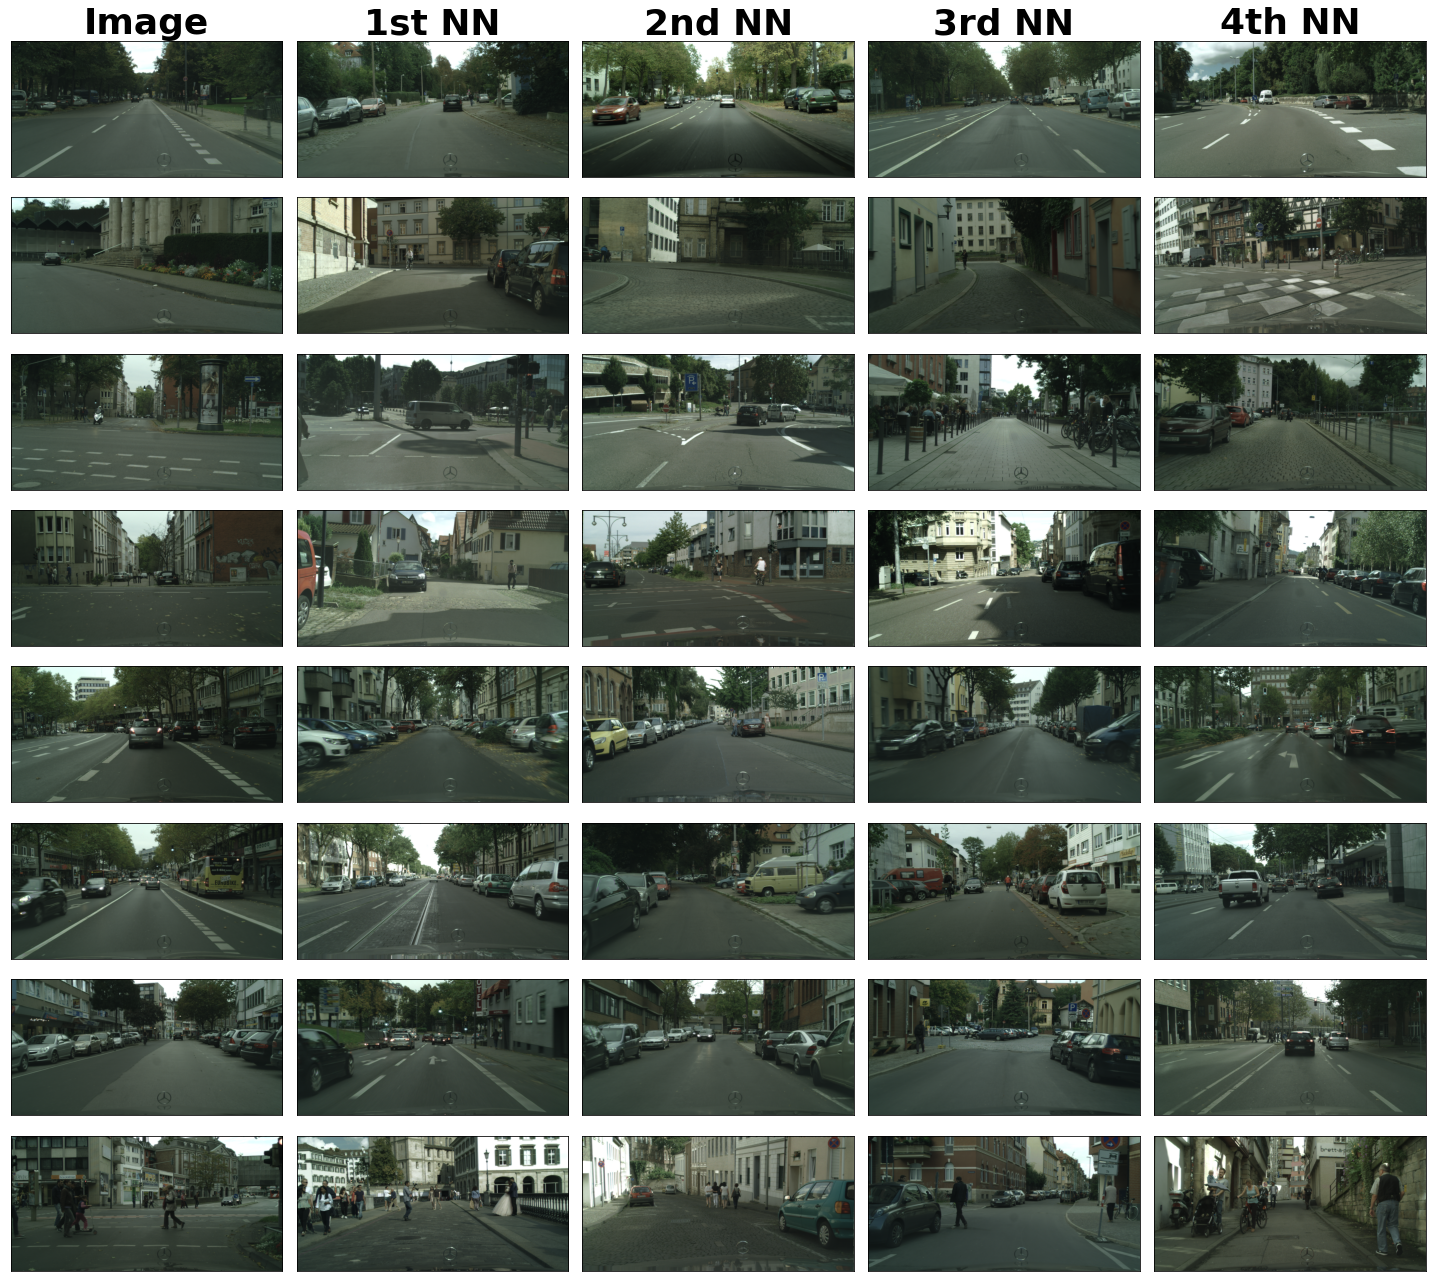

In [49]:
import matplotlib.pyplot as plt 
from PIL import Image
import cv2 
import os 
import torchvision.transforms.functional as TF

def draw_comparison(output_name, image_list, descriptions, fl, city=True):
    assert len(descriptions) == fl.shape[1], 'len(descriptions) not match len(filenames)'
    ncol = fl.shape[1]
    nrow = len(image_list)
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, round(nrow*2.3))) #, figsize=(nrow*4, ncol*2)
    for i in range(nrow):
        for j in range(ncol):
            fn = filenames[fl[i][j].item()]
            img = Image.open(fn)
            
            ax[i, j].imshow(img)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])     
            # ax[0, j].set_xlabel(descriptions[i], fontsize=16)
            ax[0, j].set_title(descriptions[j], fontsize=36, fontweight='bold')
    # plt.title()
    plt.tight_layout() 
    plt.savefig(output_name, dpi=72)
            

# med_examples = [19,20,21,22,23,24,25,26,27,28]
med_examples = [6,7,8,9.10,11,12,13,14]
fl = nearest_neighbors[med_examples][:, :5]
print(fl.shape)
descriptions = ['Image', "1st NN", "2nd NN", "3rd NN", "4th NN"] # "2nd NN", "3rd NN", "4th NN"
draw_comparison('./more_city_KNN_examples.png', med_examples, descriptions, fl)

## plot hungarian hist and assignment


In [8]:
hist_path = r'/home/zhulifu/unsup_seg/trials_unsupervised_segmentation/gen_files/swinv2_384_hist.pth'
asgn_path = r'/home/zhulifu/unsup_seg/trials_unsupervised_segmentation/gen_files/swinv2_384_asgn.pth'

import torch 
import numpy as np 
import matplotlib.pyplot as plt 


In [9]:
hist = torch.load(hist_path)
hist.shape

torch.Size([27, 27])

In [11]:
asgn = torch.load(asgn_path)
asgn

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([23,  1, 24, 19, 21, 11, 13,  2, 10, 26,  3,  9,  8, 22, 15,  4, 25,
        16, 18,  5,  6,  7,  0, 20, 14, 12, 17]))

In [ ]:
import itertools

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("显示百分比：")
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
        print(cm)
    else:
        print('显示具体数字：')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
classes = [
            'road', 'sidewalk', 'parking', 'rail track', 'building',
            'wall', 'fence', 'guard rail', 'bridge', 'tunnel',
            'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation',
            'terrain', 'sky', 'person', 'rider', 'car',
            'truck', 'bus', 'caravan', 'trailer', 'train',
            'motorcycle', 'bicycle']
plot_confusion_matrix(hist.numpy(), classes, True, )

TypeError: unhashable type: 'slice'

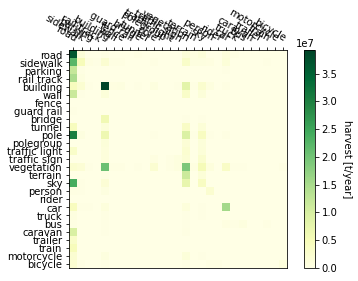

In [15]:
import matplotlib 

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

fig, ax = plt.subplots()

im, cbar = heatmap(hist, classes, classes, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()